In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import align
import logging

from cryo_md.main import run_cryomd
from cryo_md.molecular_dynamics.md_sampling import MDSampler
from cryo_md.optimization.optimizer import WeightOptimizer, PositionOptimizer
from cryo_md.image.image_stack import ImageStack
from cryo_md.utils.parser import pdb_parser
from cryo_md.pipeline.pipeline import Pipeline

logger = logging.getLogger()
fhandler = logging.FileHandler(filename='mylog.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [3]:
top_file = "ala_1.pdb"

In [4]:
image_stack = ImageStack("ala_images.npz")
ref_universe = mda.Universe(top_file)
n_models = 2
n_steps = 100

image_stack.n_images

/mnt/home/dsilvasanchez/.local/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


2000

In [5]:
md_sampler = MDSampler(
    topology_file="ala_1.pdb",
    restrain_force_constant=100000.0,
    n_steps=200,
    platform="CPU",
    properties={"Threads": "16"}
)


wts_opt = WeightOptimizer(n_steps=10, step_size=0.1)
pos_opt = PositionOptimizer(step_size=0.5, batch_size=100)

workflow = [wts_opt, pos_opt, md_sampler]

In [6]:
pipeline = Pipeline(workflow)

In [7]:
run_cryomd(
    pipeline,
    mode="all-atom",
    image_stack=image_stack,
    n_models=n_models,
    n_steps=n_steps,
    ref_universe=ref_universe
)

  0%|          | 0/100 [00:00<?, ?step/s]/mnt/home/dsilvasanchez/.local/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/mnt/home/dsilvasanchez/.local/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
 34%|███▍      | 34/100 [03:18<06:24,  5.83s/step, loss=-123616.62] 


KeyboardInterrupt: 

In [8]:
import h5py

with h5py.File("outputs.h5", "r") as file:

    losses = file["losses"][:]
    traj_wts = file["trajs_weights"][:]
    n_frames, n_models, _, n_atoms = file["trajs_positions"].shape
    univ = mda.Universe(top_file)

    for i in range(n_models):
        with mda.Writer(f"traj_{i}.pdb", n_atoms) as W:
            for j in range(34):
                univ.atoms.positions = file["trajs_positions"][j, i, :, :].T
                align.alignto(univ, ref_universe, select="not name H*", match_atoms=True)
                W.write(univ)

/mnt/home/dsilvasanchez/.local/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/mnt/home/dsilvasanchez/.local/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/mnt/home/dsilvasanchez/.local/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


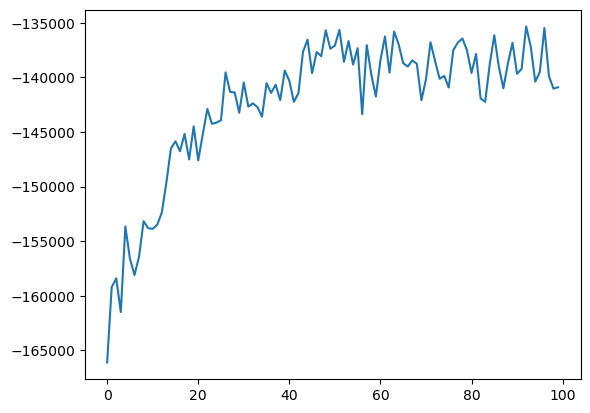

In [9]:
plt.plot(losses)

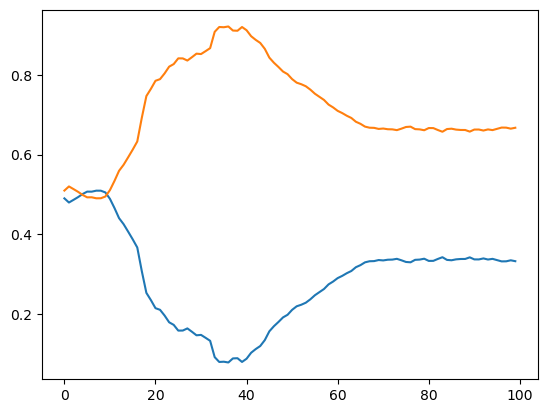

In [10]:
plt.plot(traj_wts)